## Photometric stereo  
EECS 551, F21  
2021-09-26 Julia 1.6.3

This notebook derives and implements an algorithm from computer vision called *photometric stereo* that reconstructs a 3D object from 2D images of it under different lighting conditions.

In [2]:
using IterativeSolvers: lsqr # add this package if you do not have it yet
using Plots: surface
using MIRTjim: jim
using LinearAlgebra
using Plots

In [2]:
import Pkg; Pkg.add("IterativeSolvers")

    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


Previous homework solution files used below
(these must be in your directory for "include" here to work).

In [3]:
dir = "../" # replace with "./" or your path
include(dir * "compute_normals.jl")
include(dir * "first_diffs_2d_matrix.jl")

SystemError: SystemError: opening file "/Users/darrenjiang/Desktop/Umich/Umich/EECS 551/Homework/Hw5/compute_normals.jl": No such file or directory

## Images to normals

Suppose we are in a dark room, and we have an object, a camera fixed above it,
and a moveable light source.
We model the object as a surface $f$ in $\mathbb{R}^3$,
and, without loss of generality,
we choose a coordinate system so that our camera,
which takes $m \times n$ photos,
captures the point $f(x,y)$ on the object's surface into pixel $I(x,y)$.

Let's load some example images of this kind and visualize them.

In [3]:
# copy files from web to local directory, if not here already
files = ("cat_xy_data.float32", "cat_xy_L.float32", "cat_xy_mask.uint8")
url = "http://web.eecs.umich.edu/~fessler/course/551/data/cat/"
for file in files
    if !isfile(file)
        download(url * file, file)
    end
end

In [4]:
# load data from files
dim = (430, 550, 12) # data size for 12 light positions
data = Array{Float32}(undef, dim)
read!(files[1], data)
L = Array{Float32}(undef, (3, dim[3]))
read!(files[2], L)
M = Array{Bool}(undef, dim[1:2])
read!(files[3], M)
@show m, n, d = dim

(m, n, d) = dim = (430, 550, 12)


(430, 550, 12)

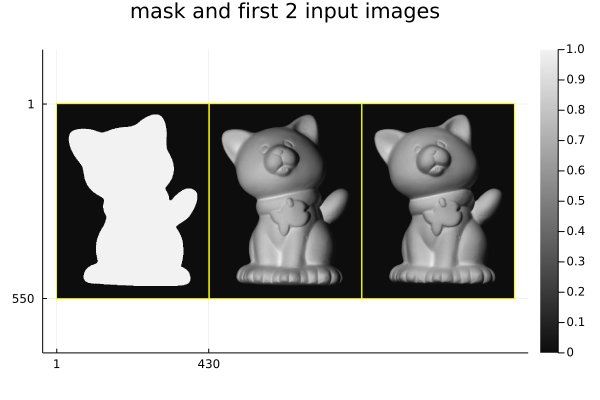

In [5]:
# show mask and p ≤ d of the input images
p = 2
# rowify = (I3) -> reshape(permutedims(I3, [1 3 2]), :, size(I3,2))
jim(cat(M, data[:,:,1:p], dims=3), "mask and first $p input images")

Intuitively, the pixel intensity $I(x,y)$ in the above images
is determined by the how much light reflects off the surface $f(x,y)$.
Indeed, assuming our object is diffuse (also called matte or Lambertian),
one can derive the relationship

$$
I(x,y) = \alpha(x,y) (\mathbf{\ell}^T \mathbf{n}(x,y))
$$

where $\mathbf{\ell} \in \mathbb{R}^3$ is a unit vector
describing the orientation of the incident light rays on the surface,
$\mathbf{n}(x,y) \in \mathbb{R}^3$ is the unit-norm surface normal vector
of $f$ at $(x,y)$,
and $\alpha(x,y) > 0$ is a scaling constant called the surface albedo.

Suppose that we have $d$ images $I_1,\ldots,I_d$ of our object,
each with a different lighting direction $\ell_1,\ldots,\ell_d$.
We can stack the data into an over-determined system of the form

$$
\underbrace{\begin{bmatrix} I_1(x,y) \\ \vdots \\ I_d(x,y) \end{bmatrix}}_{=: \, g_{xy} \in \mathbb{R}^d} = \underbrace{\begin{bmatrix} \ell_1 & \ldots & \ell_d \end{bmatrix}^T}_{=:L^T} \underbrace{\left(\alpha(x,y) n(x,y)\right)}_{=: \, \rho(x,y) \in \mathbb{R}^3}.
$$

We can solve this equation for $n(x,y)$ when $d = 3$, but, in practice,
when there is noise and our assumptions do not hold exactly,
a more robust approach is to take $d > 3$ images
and approximate $n(x,y)$ by solving the least squares problem 

$$
\hat{\mathbf{\rho}}(x,y) = \arg \min_{\mathbf{r} \in \mathbb{R}^3} \| \mathbf{L}^T \mathbf{r} - \mathbf{g}_{xy} \|_2^2
$$

and taking

$$
\hat{\mathbf{n}}(x,y) = \frac{\hat{\mathbf{\rho}}(x,y)}{\| \hat{\mathbf{\rho}}(x,y) \|_2}.
$$

Now run your `compute_normals` code to do that!

In [6]:

"""
N = compute_normals(data, L)
In:
− `data` `m × n × d` matrix whose `d` slices contain `m × n` images
of a common scene under different lighting conditions
− `L` `3 × d` matrix whose columns are the lighting direction vectors
for the images in data, with `d   3`
Out:
− `N` `m × n × 3` matrix containing the unit−norm surface normal vectors
for each pixel in the scene
"""
function compute_normals(data, L)
    
    m, n, d= size(data) 
    data =reshape(data, m * n, d) # data become (m*n) * d matrix 
    
    L = mapslices(normalize, L, dims=1) #norm vectors of lighting direction
    
    N = data * pinv(L)
    N = reshape(N, m, n, 3)
    N = mapslices(normalize, N, dims = 3)  #unit-norm surface normal vectors for each pixel in a scene
    
    return N
    
end 


compute_normals

In [7]:
# Compute unit-normals from images
N = compute_normals(data, L)
@show size(N)

size(N) = (430, 550, 3)


(430, 550, 3)

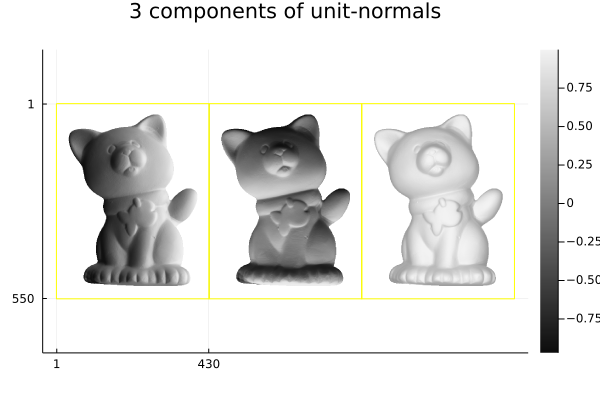

In [8]:
# display the 3 components of the normal vectors as images
jim(N, title = "3 components of unit-normals")

## Normals to gradients

Now that we have the normal vectors of our surface,
we reconstruct the surface itself!

Recall from vector calculus that we can express the surface normal vector as

$$
\hat{\mathbf{n}}(x,y) = \frac{\begin{bmatrix} -\displaystyle\frac{\partial f(x,y)}{\partial x}, & -\displaystyle\frac{\partial f(x,y)}{\partial y}, & 1 \end{bmatrix}^T}{\sqrt{1 + \displaystyle\frac{\partial f(x,y)}{\partial x}^2 + \displaystyle\frac{\partial f(x,y)}{\partial y}^2}},
$$

where $~\partial f(x,y) / \partial x~$ and $~\partial f(x,y) / \partial y~$ are the partial derivatives of $f$ with respect to $x$ and $y$. From the above equation, we can compute the partial derivatives as follows

$$
\frac{\partial f(x,y)}{\partial x} = -\frac{n_1(x,y)}{n_3(x,y)}
$$

$$
\frac{\partial f(x,y)}{\partial y} = -\frac{n_2(x,y)}{n_3(x,y)},
$$

where

$$
\hat{\mathbf{n}}(x,y) = \begin{bmatrix} n_1(x,y), & n_2(x,y), & n_3(x,y) \end{bmatrix}^T.
$$

Now compute approximate the $x$ and $y$ gradients of our surface
using the above strategy.

In [9]:
# Compute gradients from normals
DFDX = -N[:, :, 1] ./ N[:, :, 3]
DFDY = -N[:, :, 2] ./ N[:, :, 3]
DFDX[.!isfinite.(DFDX) .| .!M] .= 0 # Clean data and apply mask
DFDY[.!isfinite.(DFDY) .| .!M] .= 0 # Clean data and apply mask
@show size(DFDX)
@show size(DFDY)

size(DFDX) = (430, 550)
size(DFDY) = (430, 550)


(430, 550)

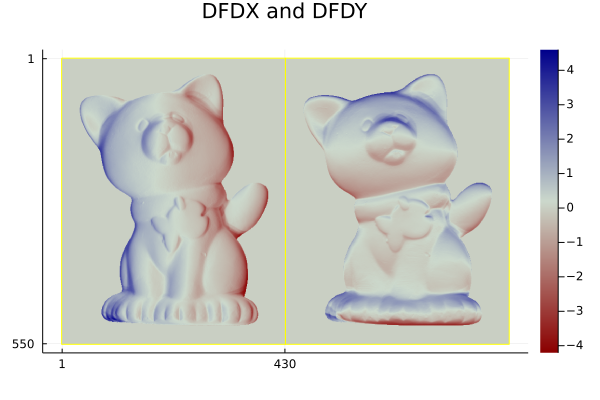

In [10]:
# display the gradients
jim(cat(DFDX, DFDY, dims=3), # feline pun intended?
    color=:redsblues,
    title = "DFDX and DFDY")

## Gradients to surface

To estimate the surface from its gradients, use the finite differences approximations:

$$
\begin{array}{rcl}
\displaystyle\frac{\partial f(x,y)}{\partial x} &\approx& \displaystyle\frac{f(x + 1,y) - f(x,y)}{(x + 1) - x} \\
&=& f(x + 1,y) - f(x,y)
\end{array}
$$

and

$$
\begin{array}{rcl}
\displaystyle\frac{\partial f(x,y)}{\partial y} &\approx& \displaystyle\frac{f(x,y + 1) - f(x,y)}{(y + 1) - y} \\
&=& f(x,y + 1) - f(x,y),
\end{array}
$$

These relationships give us an overdetermined linear system of $2mn$ equations that we can solve to estimate our surface $f(x,y)$ given its partial derivatives on the grid
$x = 1,\ldots,m$ and
$y = 1,\ldots,n$.

To simplify notation,
define the $m \times n$ matrices `FXY`, `DFDX`, and `DFDY` such that

$$
\begin{array}{rcl}
\texttt{FXY(i,j)} &=& f(i,j) \\
\texttt{DFDX(i,j)} &=& \frac{\partial f(i,j)}{\partial x} \\
\texttt{DFDY(i,j)} &=& \frac{\partial f(i,j)}{\partial y}
\end{array}
$$

Then, if we let $\mathbf{A}$ denote the 2D first differences matrix returned by your
`first_diffs_2d_matrix`  function, then we have the relationship

$$ \texttt{b} \approx \mathbf{A} ~ \texttt{fxy} $$

where, in Julia:

```julia
b = [vec(DFDX); vec(DFDY)]
fxy = vec(FXY)
```

Now construct this system!

In [11]:
# Generate least squares problem
A = first_diffs_2d_matrix(m, n)
b = [vec(DFDX); vec(DFDY)] # stacking up the differences into a vector for LS

@show size(A)
@show size(b);

size(A) = (473000, 236500)
size(b) = (473000,)


Now that we have `A` and `b`,
what remains is to solve the least squares problem

$$
\texttt{fxy} = \arg\min_{\mathbf{f} \in \mathbb{R}^{mn}}
\| \mathbf{A} \mathbf{f} - \mathbf{b} \|^2
$$

for our (vectorized) surface, `fxy`.

Because `A` is a *gigantic* (sparse) matrix with over **100 billion** entries,
computing $\mathbf{A}^+ \mathbf{b}$ directly is impossible!

Instead, we use the iterative algorithm `lsqr`
(from `IterativeSolvers` package) to do the job.

In [12]:
# Solve least squares problem (patience needed)
if !@isdefined(fxy)
    fxy = lsqr(A, b, maxiter=1000)
end

@show size(fxy);

size(fxy) = (236500,)


All that remains is to reshape back into a surface and view the results.

In [13]:
# Reshape into surface
FXY = reshape(fxy, m, n)

# Format surface
FXY .-= minimum(FXY[M]) # Anchor to z axis
FXY .*= M               # Zero data outside of mask
@show size(FXY);

size(FXY) = (430, 550)


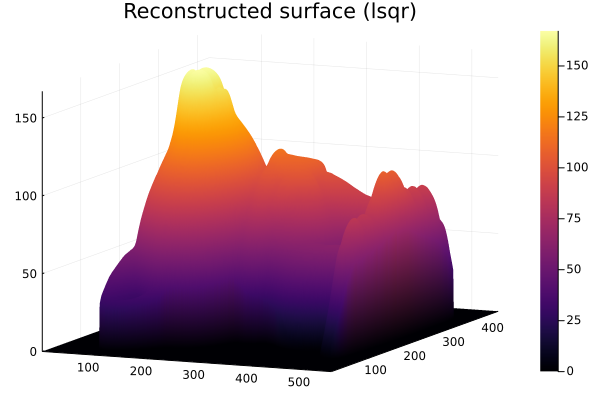

In [16]:
# Plot surface
#=
If you uncomment the following line you will be able to make a somewhat
prettier surface than the default `gr()` backend to the `Plots` package,
but you will also have to install the `PyPlot` package to use it and it
may take longer to render.  So this is definitely not required.
=#
# pyplot() # optional to uncomment this
surface(FXY, title = "Reconstructed surface (lsqr)")

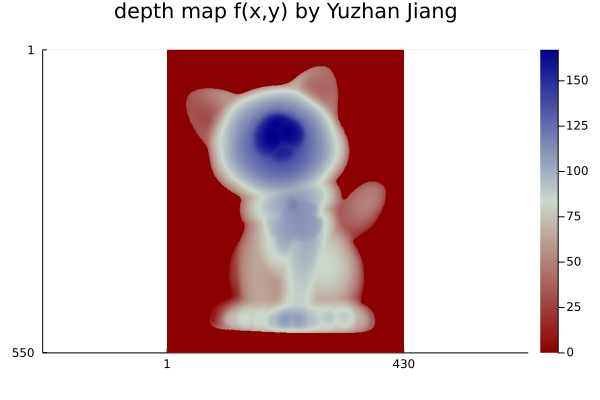

In [18]:
# also display surface as an "image"
jim(FXY, color=:redsblues,
    title = "depth map f(x,y) by $("Yuzhan Jiang")")

In [17]:
using LinearAlgebra
using SparseArrays
"""
D = Construct_D(m)
In:
 `m` is positive number
Out:
 `D` is a `mxm' circulant first finite difference matrix
"""
function Construct_D(m)
    # D = spdiagm(0 => -1* ones(m), 1 => ones(m-1), 1-m => [-1])
    D = spdiagm(0 => -1* ones(m), 1 => ones(m-1))
    D[m ,1 ] = 1
    return D
end 
   

"""
A = first_diffs_2d_matrix(m, n)
In:
    `m` and `n` are positive integers
Out:
     `A` is a `2mn * mn` sparse matrix such that `A * vec(X)` computes the
first differences down the columns (along x direction)
and across the (along y direction) of the `m * n` matrix `X`.
"""
function first_diffs_2d_matrix(m, n)
    A = zeros(eltype(0.0), 2*m*n, m*n)
    Dm = Construct_D(m)
    Dn = Construct_D(n)
    # display(Dm)
    # display(Dn)
    Im = I(m)
    In = I(n)

    A = [kron(In, Dm) ; kron(Dn, Im)]
    return A 
end 
 

# A = first_diffs_2d_matrix(2,3)
# display(A)

# fxy = [0, 4 ,1, 9, 3, 15]
# dfdx = [4, -4, 8, -8, 12, -12]
# dfdy = [1, 5, 2, 6,-3,-11]

# A * fxy == vcat(dfdx, dfdy)


# m = 30; n = 20 ;
# X = Float64.([(x-12)^2+(y-8)^2 < 5^2 for x=1:m, y=1:n])
# dfdx = diff(X; dims=1)
# dfdy = diff(X; dims=2)
# jim(
#     jim(X, "FXY: f(x,y)"; xlabel="x", ylabel="y"),
#     jim(dfdx, "DFDX: df(x,y) / dx"; xlabel="x", ylabel="y"),
#     jim(dfdy, "DFDY: df(x,y) / dy"; xlabel="x", ylabel="y"),
# )






first_diffs_2d_matrix

In [1]:
using SparseArrays
using LinearAlgebra: I
function first_diffs_2d_matrix(m,n)
    D(a)=spdiagm(0=>-ones(a),1=>ones(a-1),1-a=>ones(1))
    A=[kron(I(n),D(m));kron(D(n),I(m))]
    return A
end



first_diffs_2d_matrix (generic function with 1 method)

In [ ]:
A = [1 1; 1 1 ]
